In [1]:
!pip install d2l
!pip install matplotlib==3.0.2

     |████████████████████████████████| 82 kB 486 kB/s 
     |████████████████████████████████| 9.9 MB 8.5 MB/s 
     |████████████████████████████████| 10.3 MB 27.0 MB/s 
     |████████████████████████████████| 61 kB 7.0 MB/s 
     |████████████████████████████████| 82 kB 598 kB/s 
     |████████████████████████████████| 9.9 MB 27.2 MB/s 
     |████████████████████████████████| 20.1 MB 12.2 MB/s 
     |████████████████████████████████| 11.6 MB 41.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplo

     |████████████████████████████████| 12.9 MB 4.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Dense Blocks

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [4]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

Transition Layers

In [5]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

**DenseNet Model**

In [7]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [9]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

Training

loss 0.138, train acc 0.949, test acc 0.869
776.3 examples/sec on cuda:0


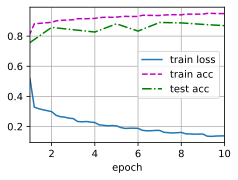

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**Summary**

* In terms of cross-layer connections, unlike ResNet, where inputs and outputs are added together, DenseNet concatenates inputs and outputs on the channel dimension.
* The main components that compose DenseNet are dense blocks and transition layers.
* We need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.